In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

keras = tf.keras

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## 데이터 다운로드

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete43ACTQ/cifar10-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete43ACTQ/cifar10-test.tfrecord
Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# (이미지, 레이블) 쌍으로 이루어져 있고 이미지는 3개 채널로 구성되며 레이블은 스칼라로 구성되어 있음
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


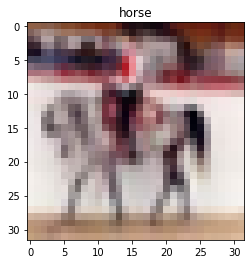

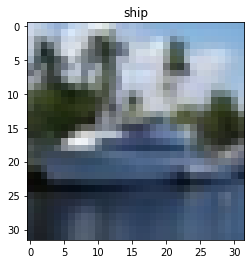

In [ ]:
# 훈련용 데이터셋에서 처음 두개의 이미지 및 레이블을 보여줌
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

## 데이터 포맷
- `tf.image` 모듈을 사용해서 이미지를 포맷
- 이미지를 고정된 입력 크기로 조정하고 입력 채널의 크기를 [-1, 1] 범위로 조정

In [ ]:
IMG_SIZE = 224 # 모든 이미지는 224x224으로 크기가 조정됩니다

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## 사용할 모델 가져오기

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [ ]:
# 기본 모델 아키텍처를 살펴봅니다.
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  keras.layers.Dense(1028, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1028)              2106372   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               526848    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 24,569,902
Trainable params: 24,535,470
Non-trainable params: 34,432
_______________________________________

In [ ]:
initial_epochs = 10
validation_steps=20

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
1250/1250 [==============================] - 339s 265ms/step - loss: 0.5853 - accuracy: 0.8116 - val_loss: 0.2055 - val_accuracy: 0.9328
Epoch 2/10
1250/1250 [==============================] - 326s 261ms/step - loss: 0.1675 - accuracy: 0.9435 - val_loss: 0.1857 - val_accuracy: 0.9412
Epoch 3/10
1250/1250 [==============================] - 327s 261ms/step - loss: 0.1172 - accuracy: 0.9622 - val_loss: 0.1840 - val_accuracy: 0.9448
Epoch 4/10
1250/1250 [==============================] - 326s 260ms/step - loss: 0.0883 - accuracy: 0.9714 - val_loss: 0.1790 - val_accuracy: 0.9508
Epoch 5/10
1250/1250 [==============================] - 326s 261ms/step - loss: 0.0713 - accuracy: 0.9774 - val_loss: 0.1932 - val_accuracy: 0.9414
Epoch 6/10
1250/1250 [==============================] - 327s 261ms/step - loss: 0.0741 - accuracy: 0.9774 - val_loss: 0.1852 - val_accuracy: 0.9460
Epoch 7/10
1250/1250 [==============================] - 327s 261ms/step - loss: 0.0651 - accuracy: 0.9797 - val_

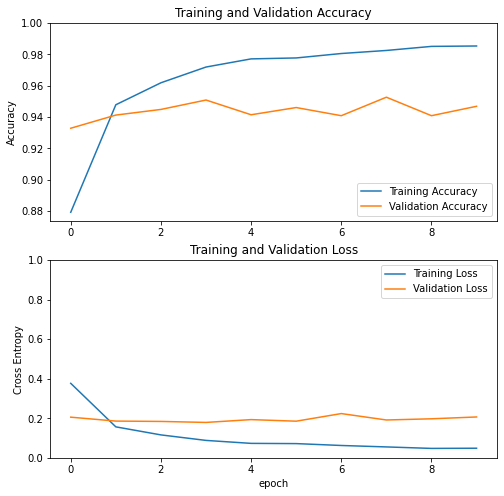

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, acc = model.evaluate(test_batches, batch_size=64)
print('loss from test data', loss)
print('accuracy from test data ', acc)

157/157 [==============================] - 11s 68ms/step - loss: 0.2141 - accuracy: 0.9446
loss from test data 0.21408864855766296
accuracy from test data  0.944599986076355
